# Homework 3 - Unsupervised Learning
## Name: Sondre Kongsgaard
## Collaboration group: Anders Vagle, Brage Saether, Morten Lie

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

N = 200 # Number of samples

def generate_gaussian_components(N):
    m_1 = [0, 0]
    C_1 = [[2, 0], [0, 1]]
    m_2 = [-2, 1]
    C_2 = [[9.0/8, 7.0/8], [7.0/8, 9.0/8]]
    m_3 = [3, 2]
    C_3 = [[2, 1], [1, 2]]
    
    pi_1 = 1.0/2
    pi_2 = 1.0/6
    
    x = np.zeros((N, 2))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < pi_1):
            #print(1)
            x[i, :] = np.random.multivariate_normal(m_1, C_1, 1)
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            #print(2)
            x[i, :] = np.random.multivariate_normal(m_2, C_2, 1)
            z[i][1] = 1
        else:
            #print(3)
            x[i, :] = np.random.multivariate_normal(m_3, C_3, 1)
            z[i][2] = 1
    return x, z

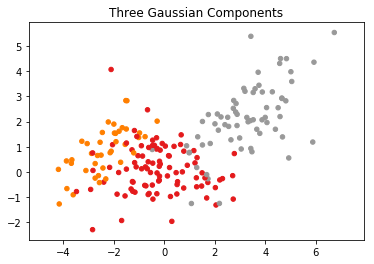

In [2]:
# Three Gaussian components, N samples
x, z = generate_gaussian_components(N)
plt.scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
plt.axis('equal')
plt.title("Three Gaussian Components")
plt.show()

# 1) Implementation of K-means algorithm

In [3]:
def k_means(N, K, C, x):
    m = np.zeros((K, np.size(x, 1)))
    C_new = np.zeros((N, 1))
    while True:
        # Update step
        for j in range(K):
            C_abs = 0
            for i in range(N):
                if C[i] == j+1:
                    C_abs += 1
                    m[j] += x[i]
            if C_abs == 0:
                C_abs = 1
            m[j] /= C_abs
        
        # Assignment step
        for i in range(N):
            min_distance = math.inf
            for j in range(K):
                distance = np.linalg.norm(x[i] - m[j])
                if distance < min_distance:
                    C_new[i] = j+1
                    min_distance = distance
        
        # Check for convergence
        if np.all(C_new == C):
            return m, C_new
        
        C = C_new
        
def mean_squared_error(x, m, C):
    N = len(x)
    K = len(m)
    smse = np.zeros((K,1))
    for i in range(N):
        j = int(C[i])
        smse[j-1] += np.linalg.norm(x[i] - m[j-1])
    return np.sum(smse) / N

In [4]:
n_random_initializations = 5
K_max = 5

m_optimal = np.zeros((K_max, 2, K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, x)
        mse = mean_squared_error(x, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

#print("C_optimal: ", C_optimal)
#print("m_optimal: ", m_optimal)

K-means complete


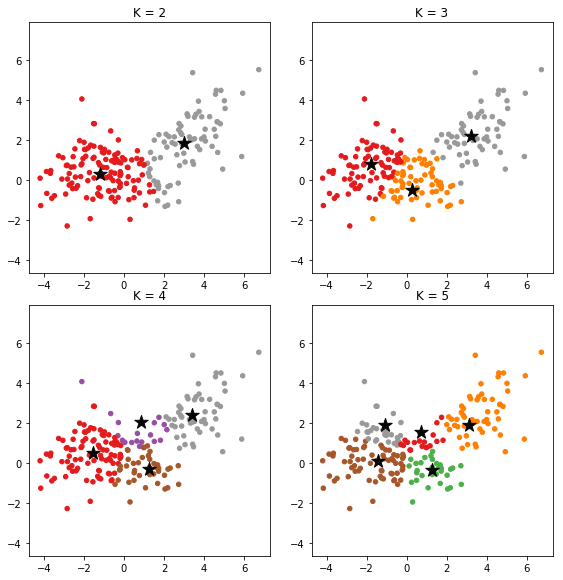

In [5]:
# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(a[:,:,K-1])[1], s=20, cmap='Set1')
    axes[row, col].scatter(m_optimal[0:K, :, K-1][:, 0], m_optimal[0:K, :, K-1][:, 1], marker='*', s=200, c='#050505')
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

In [6]:
def empirical_probabilities():
    empirical_probabilities = np.zeros((3, K_max, K_max))
    for K in range(2, K_max+1):
        for li in range(3):
            for j in range(K):
                num_a = 0
                num_z = 0
                for i in range(N):
                    if z[i, li] == 1:
                        num_z += 1
                        if a[i, j, K-1] == 1:
                            num_a += 1
                empirical_probabilities[li, j, K-1] = num_a / num_z
    return empirical_probabilities

print(empirical_probabilities())

[[[0.         0.84946237 0.38709677 0.52688172 0.12903226]
  [0.         0.15053763 0.59139785 0.09677419 0.27956989]
  [0.         0.         0.02150538 0.3655914  0.01075269]
  [0.         0.         0.         0.01075269 0.46236559]
  [0.         0.         0.         0.         0.11827957]]

 [[0.         1.         1.         0.975      0.        ]
  [0.         0.         0.         0.025      0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.6       ]
  [0.         0.         0.         0.         0.4       ]]

 [[0.         0.07462687 0.01492537 0.01492537 0.11940299]
  [0.         0.92537313 0.13432836 0.11940299 0.07462687]
  [0.         0.         0.85074627 0.10447761 0.79104478]
  [0.         0.         0.         0.76119403 0.        ]
  [0.         0.         0.         0.         0.01492537]]]


Read the table above as for each _true_ class (e.g. 3), if K is e.g. 2, the conditional probabilities for each assigned class are printed in the second column in the third 2D table.

# 2) Implementation of EM algorithm

In [7]:
from scipy.stats import multivariate_normal

def EM(m, C, pi, N, K, x, max_iter=10):
    for iter in range(max_iter):
        # Assignment step (E step)
        p_k = np.zeros((N, K))
        for i in range(N):
            pi_norm_distribution = np.zeros((K,1))
            for j in range(K):
                mvn = multivariate_normal(m[j], C[j])
                pi_norm_distribution[j] = pi[j] * mvn.pdf(x[i, :])
            for j in range(K):
                p_k[i, j] = pi_norm_distribution[j] / np.sum(pi_norm_distribution)
            
        # Update step (M step)
        for j in range(K):
            num = 0
            for i in range(N):
                num += p_k[i, j] * x[i, :]
            m[j] = num / np.sum(p_k[:, j])
            
            num = 0
            for i in range(N):
                num += p_k[i, j] * np.outer(x[i, :] - m[j], x[i, :] - m[j])
            C[j] = num / np.sum(p_k[:, j])
            
            pi[j] = np.sum(p_k[:, j]) / N

    return m, C, pi, p_k
        
m_EM = np.zeros((K_max, 2, K_max))
C_EM = np.zeros((K_max, K_max, 2, 2))
p_k_EM = np.zeros((K_max, N, K_max))
for K in range(2, K_max+1):
    C_EM_initial = np.repeat(np.eye(2)[np.newaxis, :, :], K, axis=0)
    m_EM_initial = m_optimal[0:K, :, K-1]
    pi_EM_initial = 1/K * np.ones((K,1))

    m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x)

print("EM complete")

EM complete


In [8]:
p_k_average = np.zeros((K_max, 3, K_max))
for K in range(2, K_max+1):
    n = np.zeros(3)
    for i in range(N):
        for li in range(3):
            if z[i, li] == 1:
                p_k_average[K-1, li, K-1] += p_k_EM[K-1, i, K-1]
                n[li] += 1
    for li in range(3):
        p_k_average[K-1, li, K-1] /= n[li]

print(p_k_average)
for i in range(3):
    print(np.sum(p_k_average[i]))

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 1.34503038e-01 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 2.10012957e-04 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 8.75196942e-01 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 4.55536706e-02 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.26813604e-04 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 8.57489118e-01 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.63812252e-02
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.77198540e-05
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.31959651e-01
   0.00000000e+00]]

 [[0.000

# 3) Geometrically find visualization of means and covariances as a contour plot

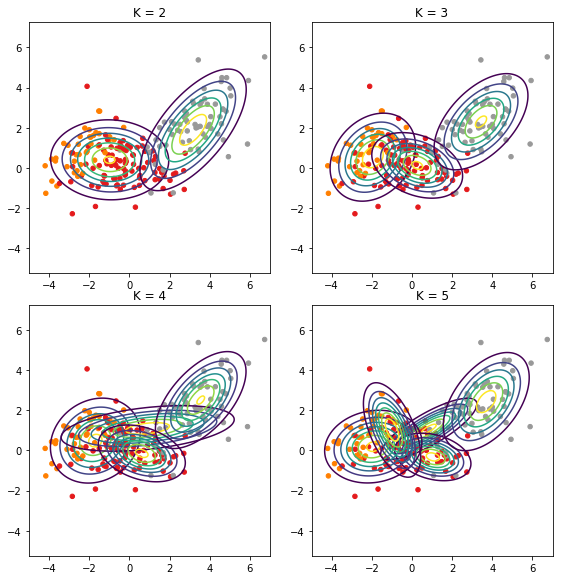

In [9]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

X = np.linspace(-5, 7, N)
Y = np.linspace(-5, 7, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
    for j in range(K):
        Z = multivariate_gaussian(pos, m_EM[j,:,K-1], C_EM[K-1, j])
        axes[row, col].contour(X, Y, Z)
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

Further experiments will be done with higher dimensional data
# 4) Generate a random vector $\mathbf{u}$ in $d$ dimensions

In [10]:
d = 30

def generate_random_vector(d):
    u = np.zeros((d, 1)) 
    P_1 = 2.0/3
    P_2 = 1.0/6
    for i in range(d):
        a = random.uniform(0, 1)
        if (a < P_1):
            u[i] = 0
        elif (a < P_1 + P_2):
            u[i] = 1
        else:
            u[i] = -1
    return u

u = np.zeros((d, 7))
for j in range(7):
    u[:,j] = generate_random_vector(d).T
print(u) # Manually inspect that the vectors u_j, j=1,...,7 are quasi-orthogonal

[[ 0.  1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.  1.]
 [ 0.  1.  0.  0. -1.  1.  0.]
 [ 1.  0.  1.  1.  1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0. -1.]
 [ 0.  0.  0. -1.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [-1.  0.  1.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1. -1.  0.]
 [ 0.  1.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  1. -1. -1.]
 [ 0.  0.  0. -1.  0.  0.  1.]
 [ 1. -1.  0.  0.  1. -1. -1.]
 [ 0.  1.  1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0. -1.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.]
 [-1.  0.  0.  0.  0. -1.  0.]
 [-1.  0.  0.  0.  1.  0.  0.]
 [-1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0. -1.]
 [ 0.  0. -1.  0. -1.  0.  0.]]


# 5) Generate $d$-dimensional  data samples for a Gaussian mixture distribution with 3 equiprobable components

In [11]:
def generate_d_dimensional_gaussian_components(N, d, u):

    pi_1 = 1.0 / 3
    pi_2 = 1.0 / 3

    sigma_squared = 0.01

    x = np.zeros((N, d))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(N):
        Z_1 = np.random.normal(0, 1, 1)
        Z_2 = np.random.normal(0, 1, 1)
        noise = np.random.multivariate_normal(np.zeros(d), sigma_squared*np.eye(d), 1)

        a = random.uniform(0, 1)
        if (a < pi_1):
            x[i, :] = u[:, 0] + Z_1*u[:, 1] + Z_2*u[:, 2] + noise
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            x[i, :] = 2*u[:, 3] + math.sqrt(2)*Z_1*u[:, 4] + Z_2*u[:, 5] + noise
            z[i][1] = 1
        else:
            x[i, :] = math.sqrt(2)*u[:, 5] + Z_1*(u[:, 0] + u[:, 1]) + 1.0/math.sqrt(2)*Z_2*u[:,4] + noise
            z[i][2] = 1
    return x, z

# 6) Generate N data samples from the preceding model, and classify with k-means

In [12]:
N = 200 # TODO: To be determined
x, z = generate_d_dimensional_gaussian_components(N, d, u)

In [13]:
m_optimal = np.zeros((K_max, np.size(x, 1), K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, x)
        mse = mean_squared_error(x, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

K-means complete


In [14]:
# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1
        
#print(a)

In [15]:
print(empirical_probabilities())

[[[0.         0.         0.         0.         0.40625   ]
  [0.         1.         0.921875   0.421875   0.        ]
  [0.         0.         0.078125   0.015625   0.        ]
  [0.         0.         0.         0.5625     0.59375   ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         1.         0.6875     0.859375   0.        ]
  [0.         0.         0.         0.         0.453125  ]
  [0.         0.         0.3125     0.140625   0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.546875  ]]

 [[0.         0.20833333 0.         0.20833333 0.52777778]
  [0.         0.79166667 0.23611111 0.02777778 0.        ]
  [0.         0.         0.76388889 0.76388889 0.44444444]
  [0.         0.         0.         0.         0.01388889]
  [0.         0.         0.         0.         0.01388889]]]


# 7) Geometric insight into how the cluster centers found by *K*-means relate to the vectors ${\mathbf{\{u\}}_j}$ in the model

[...]

# 8) *d*-dimensional EM

In [30]:
def EM(m, C, pi, N, K, x, max_iter=10):
    for iter in range(max_iter):
        # Assignment step (E step)
        p_k = np.zeros((N, K))
        for i in range(N):
            pi_norm_distribution = np.zeros((K,1))
            for j in range(K):
                mvn = multivariate_normal(m[j], C[j])
                pi_norm_distribution[j] = pi[j] * mvn.pdf(x[i, :])
            for j in range(K):
                p_k[i, j] = pi_norm_distribution[j] / np.sum(pi_norm_distribution)
            
        # Update step (M step)
        for j in range(K):
            num = 0
            for i in range(N):
                num += p_k[i, j] * x[i, :]
            m[j] = num / np.sum(p_k[:, j])
            
            num = 0
            for i in range(N):
                num += p_k[i, j] * np.outer(x[i, :] - m[j], x[i, :] - m[j])
            C[j] = num / np.sum(p_k[:, j])
            
            pi[j] = np.sum(p_k[:, j]) / N

    return m, C, pi, p_k

m_EM = np.zeros((K_max, d, K_max))
C_EM = np.zeros((K_max, K_max, d, d))
p_k_EM = np.zeros((K_max, N, K_max))
for K in range(2, K_max+1):
    C_EM_initial = np.repeat(np.eye(30)[np.newaxis, :, :], K, axis=0)
    m_EM_initial = m_optimal[0:K, :, K-1]
    pi_EM_initial = 1/K * np.ones((K,1))

    #m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x)
    m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x, max_iter = 2)
    
print("EM complete")

EM complete


In [51]:
#print(np.size(C_EM, 0))
for K in range(1, K_max):
    w, v = np.linalg.eig(C_EM[K])
    print("K =", K+1)
    print(v)

K = 2
[[[-5.01335993e-03  5.80538678e-02 -5.92630206e-03 ...  1.78373431e-01
    2.63756579e-01 -8.21407433e-02]
  [ 2.53973874e-01  9.85768883e-02 -1.43634222e-01 ...  6.33769977e-02
    1.39939822e-01  1.71783467e-01]
  [ 5.08001011e-02 -1.54527368e-01  3.95223629e-01 ...  6.47379447e-02
    1.27858248e-01  6.74871645e-02]
  ...
  [ 4.39396219e-03 -5.38172998e-02  8.39854055e-03 ... -9.47409857e-02
    8.38205741e-02 -1.60136699e-01]
  [ 9.58595159e-04 -4.75099833e-03 -4.09290301e-03 ...  2.77370745e-01
   -9.66731590e-02 -2.29463386e-02]
  [-2.57012791e-01 -1.01103403e-01  1.48138400e-01 ...  1.47781411e-01
   -1.45103682e-01  3.02278261e-02]]

 [[-1.67851635e-01  8.83929098e-02 -2.77302091e-01 ...  1.70301986e-01
   -5.87876430e-02 -2.52120942e-03]
  [ 2.14042228e-02 -6.48663325e-02 -5.02913427e-02 ...  4.40359461e-02
    7.69805124e-02 -1.17204562e-02]
  [ 1.41336791e-01 -1.32670793e-01 -1.52724502e-01 ... -1.20088228e-01
    4.45346939e-01 -1.48130315e-01]
  ...
  [-1.82031773e-0

# 9) Deterministic annealing
Implementation:
- Initialization
- Cooling
- Check for termination
- Quenching